In [3]:
import autograd.numpy as np
from autograd import grad, hessian
import colorsys
import json
import matplotlib.pyplot as plt
import numpy as np2
from numpy.random import multivariate_normal as mvn
import pandas as pd
import random as ran
import ternary
from scipy.optimize import minimize
import seaborn as sns
from scipy.stats import norm
import scipy
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mpltern

In [4]:
class tagClass:
    """Class to store each tag coordinate data."""
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip()
        self.tagClass = tClass
    
    # Get functions
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    # Returns coordinates for 16 x 16 crop around tag centre
    def getSnip(self):
        s = 16
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [5]:
def getTags(rawData, nType):
    """Process raw data into objects of Tag class."""
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

def getPhoto(tag: tagClass):
    """Returns the image this tag is from."""
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

def getSnipPlot(tag):
    """Return a 16 x 16 pixel crop in the image for this tag."""
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo[tagY:tagY2,tagX:tagX2].astype(np.float32)

def getBayer(x, y):
    """Find Bayer filter pixel colour for given coordinate."""
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR
        
def getPixels(t: tuple, photo):
    """Returns RGB values for this tag as ratio."""
    tagX, tagX2, tagY, tagY2 = t
    red = 0
    green = 0
    blue = 0
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                red += int(photo[py, px])
            elif col == 'G':
                green += int(photo[py, px])
            else:
                blue += int(photo[py, px])
    totalSum = red + (0.5*green) + blue
    return red/totalSum, (0.5*green)/totalSum, blue/totalSum


In [6]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    """Simulate pixel value given its distance from the tag centre."""
    dist = np.sqrt(np.sum((tagCoord - pixelCoord)**2))
    # If outside tag width:
    if dist>psfWidth+0.5:
           return bgBrightness
    
    # If inside tag width:
    elif dist<psfWidth-0.5:
        return tagBrightness
    
    # If on the edge of the tag:
    else:
       return (bgBrightness*(0.5 + dist - psfWidth)-tagBrightness*(dist - psfWidth - 0.5))

def simulate_image(tagCoord, t, b, psfWidth, imgShape):
    """Call simulate for each pixel in given image."""
    pixel_value_guesses = []

    # Loop over pixel coords for each colour...
    for pixX in range(imgShape[0]):
        for pixY in range(imgShape[1]):
            # Get colour based on bayer
            colour = pixX % 2 + pixY % 2
            # Call simulate_pixel with the coords of the pixel
            # and the appropriate element from the rgb vectors...etc
            pixel_value_guesses.append(simulate_pixel([pixX, pixY], tagCoord,
                                                      t[colour], b[colour], psfWidth))
    return np.array(pixel_value_guesses).astype(np.float32)

def cost_function(params, psfWidth, trueImg):
    """Returns the sum squared error of predicted pixel values compared
    to the true image."""
    tagCoord = params[:2]
    tagBright = params[2:5]
    bgBright = params[5:]
    pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright,
                                         psfWidth, trueImg.shape)
    # Sum square error over all the pxiels between the true image
    # and the simulated image
    square_error = 0.01*np.sum([(s - a)**2 for (s, a) in zip(pixel_value_guesses,
                                                             trueImg.flatten())])
    return square_error

In [8]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [6]:
tags = getTags(raw15['0'], ['649', '655', '657', '659', '661'])
allTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
for tag in tags:
    # Get data for each tag in data
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    allTags.loc[len(allTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

realImg = getSnipPlot(allTags['Tag'].iloc[0])

def temp(p):
  return cost_function(p, 2.5, realImg)
grad(temp)(params)

array([ -38.73057853, -283.43112715,    1.62959322,    3.47760602,
         -3.45999992,   -8.16563927,   -0.73506641,   -5.89999986])

In [8]:
tagsHessInv = []
tagsX = []
#img_num = np2.linspace(0,39,40)
img_num=[1]
for image in img_num:
  tagiHessInv = []
  tagiX = []
  onlyTag0 = allTags.loc[allTags['Label']==image]
  onlyTag0.reset_index(inplace=True)

  def temp(p):
    return cost_function(p, 2.5, realImg)

  for i in range(onlyTag0.shape[0]):
      realImg = getSnipPlot(onlyTag0['Tag'].iloc[i])
      params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
      res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                  bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
      pred = np.array(simulate_image(res.x[:2], res.x[2:5], res.x[5:], 2.6, [16,16])).reshape([16,16])
      
      tagiHessInv.append(hessian(temp)(res.x))
      tagiX.append(res.x)
  tagsHessInv.append(tagiHessInv)
  tagsX.append(tagiX)

C:\Users\bencl\AppData\Local\Temp\ipykernel_22304\2074048315.py:17: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


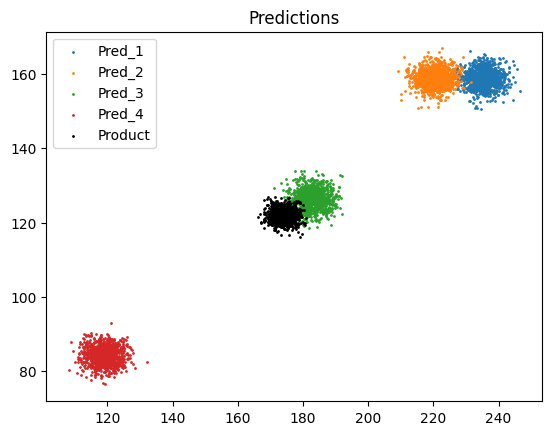

In [ ]:
covs = []
means = []

for image in range(len(img_num)): 
    # Inverse Hessian can be used as covariance of the Gaussian
    covA = np.linalg.inv(tagsHessInv[image][0][2:5,2:5])
    # Maximum-likelihood estimation gives the mean of the Gaussian
    meanA = tagsX[image][0][2:5]
    #meanA = tag0X[0]

    #plt.setp(ax, xlim=(0, 120), ylim=(0, 45))
    plt.title("Product of Gaussian densities of")
    for i in range(1,5):
        covB = np.linalg.inv(tagsHessInv[image][i][2:5,2:5])
        meanB = tagsX[image][i][2:5]


        x = mvn(meanB, covB, 1000)

        plt.scatter(x[:,0], x[:,1], 1, label="Pred_"+str(i))

        covC = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
        meanC = covC @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))

    covs.append(covC)
    means.append(meanC)



x = mvn(meanC, covC, 1000)

plt.scatter(x[:,0], x[:,1], 1, color='black', label="Product")

plt.title("Predictions")
plt.legend()

In [ ]:
entropy_samples = []
r_samples = []
g_samples = []
b_samples = []

for i in range(len(img_num)):

    n_samples = 100000
    levels = [0, 34, 66, 95, 100] 

    samples = mvn(means[i], covs[i], size=n_samples)
    samples = np.abs(samples)
    samples /= samples.sum(axis=1)[:, np.newaxis]
    r_sample, g_sample, b_sample = samples.T
    
    r_samples.append(r_sample)
    g_samples.append(g_sample)
    b_samples.append(b_sample)
    entropy_sample = np.apply_along_axis(scipy.stats.entropy, 1, samples, qk=means[i], base=3) * 20000

    entropy_samples.append(entropy_sample)

KeyboardInterrupt: 

In [ ]:
levels = [0, 34, 66, 95, 100] 
print(np2.percentile(entropy_samples,  66))

23.63298017190288


In [ ]:
mean_colour = [mean[0]/255, mean[1]/255, mean[2]/255]
print(mean_colour)

[np.float64(0.02804023048988327), np.float64(0.13953426374687591), np.float64(0.26583220634027666)]


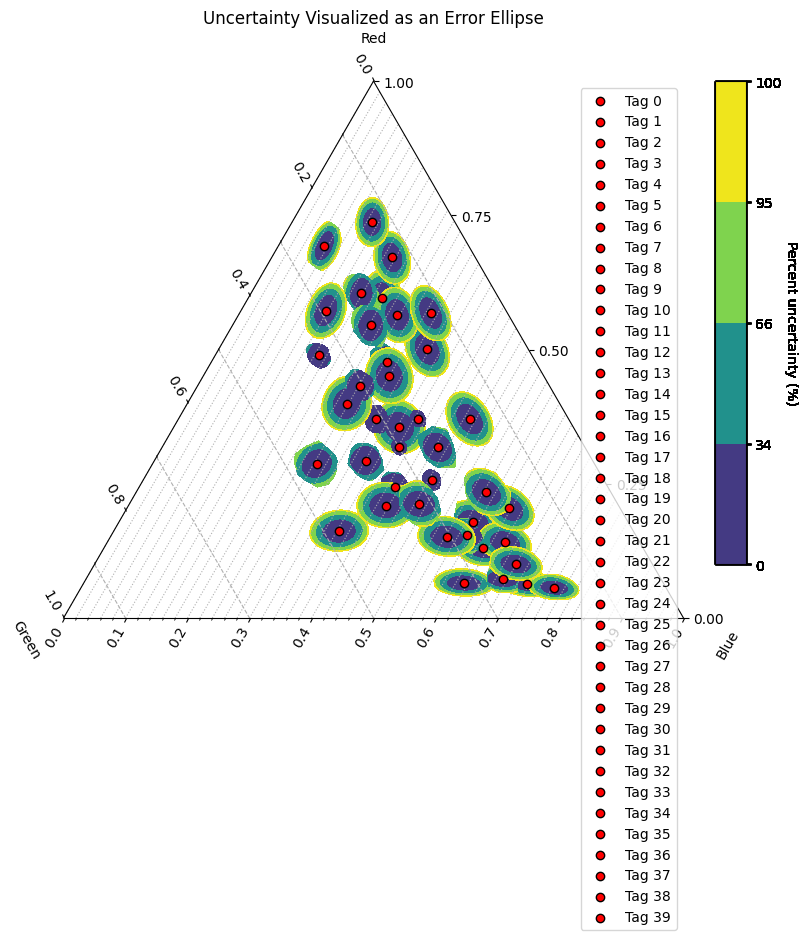

In [ ]:
fig = plt.figure(figsize=(8, 8))
bax = fig.add_subplot(projection='ternary', ternary_sum=1.0)
for i in range(len(img_num)):
    # --- Framework ---
    cs = bax.tricontourf(r_samples[i], g_samples[i], b_samples[i], entropy_samples[i], levels=levels)
    bax.set_title("tricontour")

    cax = bax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=bax.transAxes)
    colorbar = fig.colorbar(cs, cax=cax)
    colorbar.set_label('Percent uncertainty (%)', rotation=270, va='baseline')


    # Plot the mean point so it's clearly visible
    bax.scatter(means[i][0], means[i][1], means[i][2],
            c='red', edgecolors="k", zorder=10, label=f'Tag {i}')

    bax.taxis.set_major_locator(MultipleLocator(0.25))
    bax.laxis.set_major_locator(MultipleLocator(0.20))
    bax.raxis.set_major_locator(MultipleLocator(0.10))

    bax.laxis.set_minor_locator(MultipleLocator(0.1))
    bax.raxis.set_minor_locator(AutoMinorLocator(5))

    bax.grid(axis='t')
    bax.grid(axis='l', which='minor', linestyle='--')
    bax.grid(axis='r', which='both', linestyle=':')

    bax.set_title("Uncertainty Visualized as an Error Ellipse")
    bax.set_tlabel("Red")
    bax.set_llabel("Green")
    bax.set_rlabel("Blue")

    bax.legend()
plt.show()

In [8]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))
raw20 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_20m.json"))

In [9]:
tags15 = getTags(raw15['0'], ['649', '655', '657', '659', '661'])
allTags15 = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
for tag in tags15:
    # Get data for each tag in data
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    allTags15.loc[len(allTags15.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]


In [9]:
tags20 = getTags(raw20['0'], ['545', '547', '549', '551', '553', '557', '559', '561', '563', '565', '567', '569', '571', '573', '575', '577', '579', '581', '583', '585', '587', '591', '593', '595', '599', '601', '605', '607', '609', '611', '615', '617', '619', '621', '623', '625', '627', '629', '631', '645'])
allTags20 = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in tags20:
    # Get data for each tag in data
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    allTags20.loc[len(allTags20.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]


In [ ]:
tag_num= np2.linspace(0,39,40)
tagsHessInv=[]
tagsX=[]

for tag in tag_num:
  tagiHessInv = []
  tagiX = []
  onlyTag0 = allTags20.loc[allTags20['Label']==tag]
  onlyTag0.reset_index(inplace=True)

  def temp(p):
    return cost_function(p, 2.5, realImg)

  for i in range(onlyTag0.shape[0]):
      realImg = getSnipPlot(onlyTag0['Tag'].iloc[i])
      params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
      res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                  bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
      
      tagiHessInv.append(hessian(temp)(res.x))
      tagiX.append(res.x)
  tagsHessInv.append(tagiHessInv)
  tagsX.append(tagiX)

C:\Users\bencl\AppData\Local\Temp\ipykernel_21160\1919121443.py:17: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
C:\Users\bencl\AppData\Local\Temp\ipykernel_21160\1919121443.py:17: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
C:\Users\bencl\AppData\Local\Temp\ipykernel_21160\1919121443.py:17: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
C:\Users\bencl\AppData\Local\Temp\ipykernel_21160\1919121443.py:17: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
C:\Users\bencl\AppData\Local\Temp\ipykernel_21160\1919121443.py:17: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, para

In [12]:
import pickle
dbfile=open('mean_full_tags', 'rb')
tagsX = pickle.load(dbfile)

dbfile2=open('hess_full_tags', 'rb')
tagsHessInv = pickle.load(dbfile2)

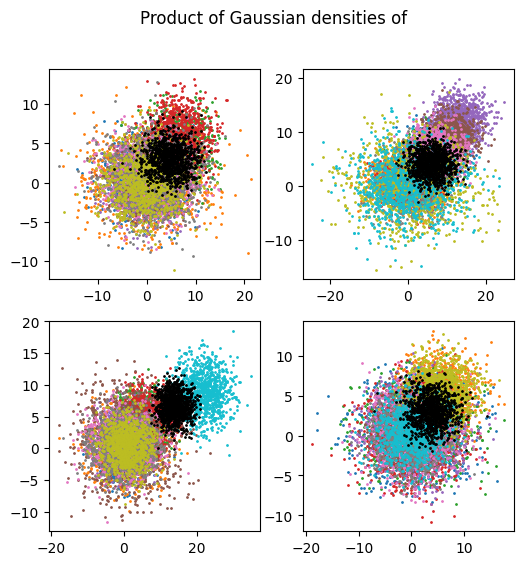

In [119]:
covs = []
means = []

img_num=[4]

fig, axes = plt.subplots(2,2, figsize=(6, 6))
fig.suptitle("Product of Gaussian densities of")

partition = [1,10,20,30,40]

count=0
for x in range(2):
    for y in range(2):
        
        for image in img_num: 
            # Inverse Hessian can be used as covariance of the Gaussian
            covA = np.linalg.inv(tagsHessInv[image][0][2:5,2:5])
            # Maximum-likelihood estimation gives the mean of the Gaussian
            meanA = tagsX[image][0][2:5]


            for i in range(partition[count],partition[count+1]):
                covB = np.linalg.inv(tagsHessInv[image][i][2:5,2:5])
                meanB = tagsX[image][i][2:5]


                z = mvn(meanB, covB, 1000)
                axes[x, y].scatter(z[:,0], z[:,1], 1, label="Pred_"+str(i))

                covC = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
                meanC = covC @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))

            covs.append(covC)
            means.append(meanC)
            count+=1
        z = mvn(meanC, covC, 1000)

        axes[x][y].scatter(z[:,0], z[:,1], 1, color='black', label="Product")


In [13]:
num_parts = 4

In [14]:
def calculate_mean_hess(tags, hess):
    covs = []
    means = []

    p=10
    start = 1
    end = p

    for tag in range(40):
        for part in range(num_parts): 
            # Inverse Hessian can be used as covariance of the Gaussian
            covA = np.linalg.inv(hess[tag][part*p][2:5,2:5])
            # Maximum-likelihood estimation gives the mean of the Gaussian
            meanA = tags[tag][part*p][2:5]

            for i in range(start + (part*p), end + (part*p)):
                covB = np.linalg.inv(hess[tag][i][2:5,2:5])
                meanB = tags[tag][i][2:5]

                covA = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
                meanA = covA @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))

            covs.append(covA)
            means.append(meanA)

    return means, covs

In [15]:
means, covs = calculate_mean_hess(tagsX, tagsHessInv)

c:\Users\bencl\AppData\Local\Programs\Python\Python312\Lib\site-packages\mpltern\_ternary_parsers.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  return f(ax, *args, **kwargs)


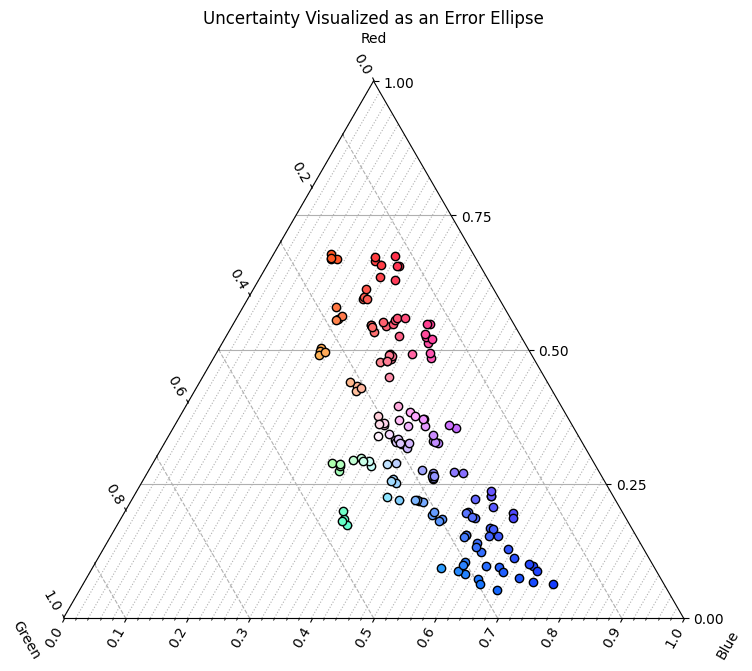

In [ ]:
# 1. SET UP THE PLOT (do this only once)
fig = plt.figure(figsize=(8, 8))
bax = fig.add_subplot(projection='ternary', ternary_sum=1.0)

# Set titles and labels once
bax.set_title("Uncertainty Visualized as an Error Ellipse")
bax.set_tlabel("Red")
bax.set_llabel("Green")
bax.set_rlabel("Blue")

# Set grid and ticks once
bax.taxis.set_major_locator(MultipleLocator(0.25))
bax.laxis.set_major_locator(MultipleLocator(0.20))
bax.raxis.set_major_locator(MultipleLocator(0.10))
bax.laxis.set_minor_locator(MultipleLocator(0.1))
bax.raxis.set_minor_locator(AutoMinorLocator(5))
bax.grid(axis='t')
bax.grid(axis='l', which='minor', linestyle='--')
bax.grid(axis='r', which='both', linestyle=':')

# 2. PLOT THE DATA (loop only over the plotting calls)
for i in range(len(means)):
    #  --- Framework ---
    cs = bax.tricontour(r_samples[i], g_samples[i], b_samples[i], entropy_samples[i], levels=levels)
    bax.set_title("tricontour")

    cax = bax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=bax.transAxes)
    colorbar = fig.colorbar(cs, cax=cax)
    colorbar.set_label('Percent uncertainty (%)', rotation=270, va='baseline')



    original_color = np.array(means[i])
    # Scale the color so its brightest component is 1.0
    max_val = np.max(original_color)
    bright_color = original_color / max_val if max_val > 0 else original_color
    # The fix: provide 'c' as an RGB color and REMOVE `norm`
    
    bax.scatter(
        means[i][0], means[i][1], means[i][2],
        c=bright_color,  # Pass the [r, g, b] list as the color
        edgecolors="k",
        zorder=10,
        label=f'Tag {i}'
    )

# 3. SHOW THE LEGEND AND PLOT (do this once, after the loop)
plt.show()


In [20]:
labels = []
[labels.extend(np.ones(4)*i) for i in range(40)]
labels = np2.array(labels)

y_test = labels[::4]
X_test = means[::4]
y_train = np.concatenate((labels[1::4], labels[2::4], labels[3::4]))
X_train = np.concatenate((means[1::4], means[2::4], means[3::4]))


In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, actual, name):
    """Calculate predicting scores based on specific metrics."""
    print(name)
    a = accuracy_score(actual, modelPred)
    print("Accuracy: ", a)
    print("F1: ", f1_score(actual, modelPred, average='macro'))
    print("Precision: ", precision_score(actual, modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(actual, modelPred, average='macro'))
    print("MSE: ", mean_squared_error(actual, modelPred), "\n")
    return a

In [1]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,8):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores(y_pred, y_test, f"KNN - {i}N")

NameError: name 'X_train' is not defined